# 1-12: 하이브리드 서빙 + 스태킹 비교

**NVIDIA AI Blueprint 패턴**: 배치 DL 임베딩 + Redis 캐싱 + 실시간 XGBoost

---

## 목표

동일 PaySim 데이터에서 **5가지 접근법** 공정 비교

| 모델 | 구성 | 추론 속도 |
|------|------|----------|
| XGBoost 단독 | 원본 피처만 | ~0.4ms |
| FT-Transformer | DL 직접 추론 | ~24ms |
| **하이브리드** | 원본 + DL 임베딩 | ~1ms |
| **스태킹** | XGB + LGBM + CatBoost | ~1.2ms |
| **하이브리드 스태킹** | 스태킹 + DL 임베딩 | ~1.5ms |

---

## 아키텍처

```
┌─────────────────────────────────────────────────────────────┐
│                 배치 파이프라인 (수동 실행)                  │
├─────────────────────────────────────────────────────────────┤
│ 1. PaySim 고객별 피처 로드                                  │
│ 2. FT-Transformer로 고객별 임베딩 계산                      │
│ 3. Redis에 저장 (tobytes + Pipeline 최적화)                │
└─────────────────────────────────────────────────────────────┘
                              ↓
┌─────────────────────────────────────────────────────────────┐
│                실시간 추론 시뮬레이션                        │
├─────────────────────────────────────────────────────────────┤
│ hybrid_predict(user_id, features)                           │
│   1. Redis에서 임베딩 조회 (0.1ms)                         │
│   2. 원본 피처 + 임베딩 결합                               │
│   3. XGBoost 추론 (0.5ms)                                  │
│ → 총 지연: ~1ms (Transformer 직접 24ms → 24배 개선)        │
└─────────────────────────────────────────────────────────────┘
```

---

## 레퍼런스

- [NVIDIA Financial Fraud Detection Blueprint](https://build.nvidia.com/nvidia/financial-fraud-detection)
- [NVIDIA Triton + XGBoost 배포](https://www.nvidia.com/en-us/launchpad/data-science/deploy-a-fraud-detection-xgboost-model-using-triton/)
- [Feature Store Summit 2024](https://www.featurestoresummit.com/fs-summit-2024/agenda-2024)

In [13]:
%%time
# 필요 패키지 설치
!pip install redis pytorch_tabular polars -q

import pandas as pd
import numpy as np
import polars as pl  # Polars: 시간 윈도우 집계 최적화 (45분 → ~1분)
import matplotlib.pyplot as plt
import time
import warnings
warnings.filterwarnings('ignore')

# ML
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve

# DL
import torch
import torch.nn as nn

# Redis
import redis

# 한글 폰트
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# GPU 확인
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Device: cuda
GPU: NVIDIA GeForce RTX 2070 SUPER
CPU times: total: 0 ns
Wall time: 1.67 s


---

## 1. Redis 연결 확인

**사전 준비**: Redis 서버 실행 필요

```bash
# Docker로 Redis 실행
docker run -d -p 6379:6379 --name redis-fds redis:7-alpine
```

In [3]:
# Redis 연결 테스트
try:
    r = redis.Redis(host='localhost', port=6379, db=0, decode_responses=False)
    r.ping()
    print("✅ Redis 연결 성공!")
    print(f"   Redis 버전: {r.info()['redis_version']}")
except redis.ConnectionError as e:
    print("❌ Redis 연결 실패!")
    print("   다음 명령으로 Redis 실행:")
    print("   docker run -d -p 6379:6379 --name redis-fds redis:7-alpine")
    raise e

✅ Redis 연결 성공!
   Redis 버전: 7.4.7


---

## 2. PaySim 데이터 로드 (1-11 재사용)

In [4]:
# PaySim 데이터 로드
df = pd.read_csv('../../data/raw/PS_20174392719_1491204439457_log.csv')
print(f"원본 데이터 크기: {len(df):,}")

# CASH_OUT, TRANSFER만 필터링 (사기 발생 유형)
df_filtered = df[df['type'].isin(['CASH_OUT', 'TRANSFER'])].copy()
print(f"필터링 후: {len(df_filtered):,}")

# 샘플링 (메모리 절약)
SAMPLE_SIZE = 1_000_000  # 1-12는 더 작은 샘플로 빠르게 검증

fraud_samples = df_filtered[df_filtered['isFraud'] == 1]
normal_samples = df_filtered[df_filtered['isFraud'] == 0].sample(
    n=min(SAMPLE_SIZE - len(fraud_samples), len(df_filtered[df_filtered['isFraud'] == 0])),
    random_state=42
)
df_sample = pd.concat([fraud_samples, normal_samples]).sort_values(['nameOrig', 'step'])

print(f"샘플링 후: {len(df_sample):,}")
print(f"사기 비율: {df_sample['isFraud'].mean()*100:.3f}%")

del df, df_filtered

원본 데이터 크기: 6,362,620
필터링 후: 2,770,409
샘플링 후: 1,000,000
사기 비율: 0.821%


---

## 3. 피처 엔지니어링 (1-11과 동일)

In [25]:
def create_time_window_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Polars 기반 시간 윈도우 집계 피처 생성 (12개)
    
    성능: Pandas 45분 → Polars ~1분
    
    핵심 API (Context7 확인):
    - group_by_dynamic: 시간 윈도우 + 파티션 지원
    - over(): 단순 윈도우 함수
    - to_dicts(): pyarrow 없이 Pandas 변환
    """
    print("시간 윈도우 집계 피처 생성 중... (Polars)")
    start_time = time.time()
    
    # Pandas → Polars 변환
    df_pl = pl.from_pandas(df)
    
    # step → datetime 변환 (1 step = 1 hour)
    df_pl = df_pl.with_columns([
        (pl.datetime(2020, 1, 1) + pl.duration(hours=pl.col('step').cast(pl.Int64))).alias('datetime')
    ])
    
    # datetime 정렬 (group_by_dynamic 필수 조건)
    df_pl = df_pl.sort(['nameOrig', 'datetime'])
    
    # 원본 인덱스 보존 (나중에 join용)
    df_pl = df_pl.with_row_index('_row_idx')
    
    # === 1. Rolling 피처 (group_by_dynamic + group_by) ===
    print("  - Rolling 피처 계산...")
    
    # 1시간 윈도우
    rolling_1h = (
        df_pl
        .group_by_dynamic('datetime', every='1h', period='1h', group_by='nameOrig', label='right')
        .agg([
            pl.len().alias('tx_count_1h'),
            pl.sum('amount').alias('amt_sum_1h'),
            pl.col('_row_idx').last().alias('_row_idx'),
        ])
    )
    
    # 24시간 윈도우
    rolling_24h = (
        df_pl
        .group_by_dynamic('datetime', every='1h', period='24h', group_by='nameOrig', label='right')
        .agg([
            pl.len().alias('tx_count_24h'),
            pl.sum('amount').alias('amt_sum_24h'),
            pl.col('_row_idx').last().alias('_row_idx'),
        ])
    )
    
    # 7일(168시간) 윈도우
    rolling_7d = (
        df_pl
        .group_by_dynamic('datetime', every='1h', period='168h', group_by='nameOrig', label='right')
        .agg([
            pl.len().alias('tx_count_7d'),
            pl.sum('amount').alias('amt_sum_7d'),
            pl.col('_row_idx').last().alias('_row_idx'),
        ])
    )
    
    # Rolling 결과 조인
    df_pl = df_pl.join(
        rolling_1h.select(['_row_idx', 'tx_count_1h', 'amt_sum_1h']), 
        on='_row_idx', how='left'
    )
    df_pl = df_pl.join(
        rolling_24h.select(['_row_idx', 'tx_count_24h', 'amt_sum_24h']), 
        on='_row_idx', how='left'
    )
    df_pl = df_pl.join(
        rolling_7d.select(['_row_idx', 'tx_count_7d', 'amt_sum_7d']), 
        on='_row_idx', how='left'
    )
    
    # === 2. 시간 간격 피처 (over 사용) ===
    print("  - 시간 간격 피처...")
    df_pl = df_pl.with_columns([
        pl.col('step').diff().over('nameOrig').fill_null(0).alias('time_since_last'),
    ])
    
    # avg_time_gap: 누적 평균 시간 간격
    df_pl = df_pl.with_columns([
        pl.col('time_since_last').cum_sum().over('nameOrig').alias('_cumsum_gap'),
        pl.lit(1).cum_sum().over('nameOrig').alias('_cumcount'),
    ])
    df_pl = df_pl.with_columns([
        (pl.col('_cumsum_gap') / pl.col('_cumcount')).fill_null(0).alias('avg_time_gap'),
    ])
    
    # === 3. 잔액 관련 피처 (inf 방지!) ===
    print("  - 잔액 피처...")
    df_pl = df_pl.with_columns([
        # balance_ratio: 0으로 나누기 방지 + clip
        pl.when(pl.col('oldbalanceOrg') > 1.0)
          .then(pl.col('newbalanceOrig') / pl.col('oldbalanceOrg'))
          .otherwise(0.0)
          .clip(-100, 100)  # 극단값 제한
          .alias('balance_ratio'),
        
        # balance_drop_pct: 0으로 나누기 방지 + clip
        pl.when(pl.col('oldbalanceOrg') > 1.0)
          .then((pl.col('oldbalanceOrg') - pl.col('newbalanceOrig')) / pl.col('oldbalanceOrg'))
          .otherwise(0.0)
          .clip(-100, 100)  # 극단값 제한
          .alias('balance_drop_pct'),
    ])
    
    # === 4. 패턴 탐지 피처 ===
    print("  - 패턴 피처...")
    df_pl = df_pl.with_columns([
        pl.lit(1).cum_sum().over(['nameOrig', 'nameDest']).alias('same_dest_count'),
        (pl.col('type') == 'TRANSFER').cast(pl.Int32).alias('_is_transfer'),
    ])
    
    df_pl = df_pl.with_columns([
        pl.col('_is_transfer').cum_sum().over('nameOrig').alias('_transfer_cumsum'),
    ])
    
    df_pl = df_pl.with_columns([
        ((pl.col('_is_transfer') == 1) & (pl.col('_transfer_cumsum') == 1))
            .cast(pl.Int32)
            .alias('is_first_transfer'),
    ])
    
    # 임시 컬럼 제거
    df_pl = df_pl.drop(['_is_transfer', '_transfer_cumsum', 'datetime', '_row_idx', '_cumsum_gap', '_cumcount'])
    
    # Null 처리 + inf 처리
    df_pl = df_pl.fill_null(0)
    df_pl = df_pl.fill_nan(0)  # NaN도 처리
    
    # Polars → Pandas 변환 (pyarrow 불필요!)
    print("  - Pandas 변환...")
    result = pd.DataFrame(df_pl.to_dicts())
    
    # 추가 안전장치: inf 값 제거
    result = result.replace([np.inf, -np.inf], 0)
    
    elapsed = time.time() - start_time
    print(f"완료! ({elapsed:.1f}초)")
    
    return result

# 피처 생성
df_features = create_time_window_features(df_sample)

# 데이터 검증
print(f"\n데이터 검증:")
print(f"  inf 개수: {np.isinf(df_features.select_dtypes(include=[np.number])).sum().sum()}")
print(f"  NaN 개수: {df_features.isna().sum().sum()}")

시간 윈도우 집계 피처 생성 중... (Polars)
  - Rolling 피처 계산...
  - 시간 간격 피처...
  - 잔액 피처...
  - 패턴 피처...
  - Pandas 변환...
완료! (19.7초)

데이터 검증:
  inf 개수: 0
  NaN 개수: 0
CPU times: total: 27.8 s
Wall time: 20.4 s


In [53]:
# 피처 정의
num_col_names = [
    'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest',
    'tx_count_1h', 'tx_count_24h', 'tx_count_7d',
    'amt_sum_1h', 'amt_sum_24h', 'amt_sum_7d',
    'time_since_last', 'avg_time_gap',
    'balance_ratio', 'balance_drop_pct',
    'same_dest_count', 'is_first_transfer'
]
cat_col_names = ['type']
target_col = 'isFraud'

# type 인코딩
le = LabelEncoder()
df_features['type_encoded'] = le.fit_transform(df_features['type'])

# 데이터 분할 (Stratified Random Split)
# PaySim은 합성 데이터 → 시간 기반 분할 불필요, 클래스 비율 유지가 중요
from sklearn.model_selection import train_test_split

train_df, temp_df = train_test_split(
    df_features, test_size=0.3, stratify=df_features['isFraud'], random_state=42
)
val_df, test_df = train_test_split(
    temp_df, test_size=0.5, stratify=temp_df['isFraud'], random_state=42
)

print(f"Train: {len(train_df):,} (사기 {train_df['isFraud'].sum():,}건, {train_df['isFraud'].mean()*100:.2f}%)")
print(f"Val:   {len(val_df):,} (사기 {val_df['isFraud'].sum():,}건, {val_df['isFraud'].mean()*100:.2f}%)")
print(f"Test:  {len(test_df):,} (사기 {test_df['isFraud'].sum():,}건, {test_df['isFraud'].mean()*100:.2f}%)")

Train: 1,082,499 (사기 17,136건, 1.58%)
Val:   231,964 (사기 3,672건, 1.58%)
Test:  231,965 (사기 3,672건, 1.58%)


---

## 4. FT-Transformer 학습 + 임베딩 추출

### 4-1. 모델 학습

In [54]:
from pytorch_tabular import TabularModel
from pytorch_tabular.models import FTTransformerConfig
from pytorch_tabular.config import DataConfig, TrainerConfig, OptimizerConfig
from pytorch_tabular.models.common.heads import LinearHeadConfig

# DataFrame 준비
train_pt = train_df[num_col_names + cat_col_names + [target_col]].copy()
val_pt = val_df[num_col_names + cat_col_names + [target_col]].copy()
test_pt = test_df[num_col_names + cat_col_names + [target_col]].copy()

print(f"FT-Transformer 데이터 준비 완료")
print(f"  수치형 피처: {len(num_col_names)}개")
print(f"  범주형 피처: {len(cat_col_names)}개")

FT-Transformer 데이터 준비 완료
  수치형 피처: 17개
  범주형 피처: 1개


In [55]:
# FT-Transformer Config (Context7 확인)
data_config = DataConfig(
    target=[target_col],
    continuous_cols=num_col_names,
    categorical_cols=cat_col_names,
    continuous_feature_transform="quantile_normal",
    normalize_continuous_features=True,
)

trainer_config = TrainerConfig(
    batch_size=1024,
    max_epochs=20,
    early_stopping="valid_loss",
    early_stopping_mode="min",
    early_stopping_patience=3,
    checkpoints="valid_loss",
    load_best=True,
    accelerator="auto",
    devices=1,
    progress_bar="simple",
)

optimizer_config = OptimizerConfig()

head_config = LinearHeadConfig(
    layers="64-32",
    dropout=0.1,
    initialization="kaiming",
).__dict__

# 임베딩 차원
EMBED_DIM = 32

model_config = FTTransformerConfig(
    task="classification",
    input_embed_dim=EMBED_DIM,
    num_attn_blocks=3,
    num_heads=4,
    attn_dropout=0.1,
    ff_dropout=0.1,
    learning_rate=1e-3,
    head="LinearHead",
    head_config=head_config,
    # Context7: metrics는 TorchMetrics에서 가져옴
    # accuracy는 예측 클래스 필요 (prob_input=False)
    metrics=["accuracy"],
    metrics_params=[{}],
    metrics_prob_input=[False],
)

print(f"임베딩 차원: {EMBED_DIM}")
print(f"총 임베딩 크기: {EMBED_DIM * (len(num_col_names) + len(cat_col_names))} (피처 수 x 임베딩 차원)")

임베딩 차원: 32
총 임베딩 크기: 576 (피처 수 x 임베딩 차원)


In [56]:
# 모델 학습
print("=" * 60)
print("FT-Transformer 학습")
print("=" * 60)

start_time = time.time()

tabular_model = TabularModel(
    data_config=data_config,
    model_config=model_config,
    optimizer_config=optimizer_config,
    trainer_config=trainer_config,
    verbose=True,
)

tabular_model.fit(train=train_pt, validation=val_pt)

tf_train_time = time.time() - start_time
print(f"\nFT-Transformer 학습 완료! ({tf_train_time:.1f}초)")

FT-Transformer 학습


2026-01-08 04:09:40,624 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2026-01-08 04:09:40,754 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2026-01-08 04:09:41,405 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2026-01-08 04:09:46,594 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: FTTransformerModel

2026-01-08 04:09:46,990 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2026-01-08 04:09:47,072 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                  | Params | Mode 
-------------------------------------------------------------------
0 | _backbone        | FTTransformerBackbone | 86.6 K | train
1 | _embedding_layer | Embedding2dLayer      | 1.3 K  | train
2 | _head            | LinearHead            | 4.3 K  | train
3 | loss             | CrossEntropyLoss      | 0      | train
-------------------------------------------------------------------
92.1 K    Trainable params
0         Non-trainable params
92.1 K    Total params
0.368     Total estimated model params size (MB)
76        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                                       | 0/?…

Training: |                                                                                              | 0/?…

Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

2026-01-08 04:14:57,402 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2026-01-08 04:14:57,404 - {pytorch_tabular.tabular_model:1529} - INFO - Loading the best model


FT-Transformer 학습 완료! (316.9초)


In [57]:
# 모델 저장
import os
model_save_path = "../../models/ft_transformer_paysim"
os.makedirs(model_save_path, exist_ok=True)
tabular_model.save_model(model_save_path)
print(f"모델 저장: {model_save_path}")

2026-01-08 04:25:54,919 - {pytorch_tabular.tabular_model:1575} - WARNING - Directory is not empty. Overwriting the 
contents.

모델 저장: ../../models/ft_transformer_paysim


In [58]:
# 테스트 평가
tf_pred_df = tabular_model.predict(test_pt)
prob_col = [c for c in tf_pred_df.columns if '1_probability' in c][0]
tf_pred = tf_pred_df[prob_col].values

tf_auc = roc_auc_score(test_pt[target_col], tf_pred)
tf_auprc = average_precision_score(test_pt[target_col], tf_pred)

print(f"FT-Transformer 결과:")
print(f"  AUC: {tf_auc:.4f}")
print(f"  AUPRC: {tf_auprc:.4f}")

FT-Transformer 결과:
  AUC: 0.9995
  AUPRC: 0.9865


### 4-2. 임베딩 추출

**FT-Transformer 구조**:
```
Input → Embedding Layer → Transformer Backbone → Head → Output
                              ↓
                    이 부분을 임베딩으로 사용!
```

In [59]:
# 모델 구조 확인
print("FT-Transformer 모델 구조:")
print(tabular_model.model)

FT-Transformer 모델 구조:
FTTransformerModel(
  (_backbone): FTTransformerBackbone(
    (add_cls): AppendCLSToken()
    (transformer_blocks): Sequential(
      (mha_block_0): TransformerEncoderBlock(
        (mha): MultiHeadedAttention(
          (to_qkv): Linear(in_features=32, out_features=384, bias=False)
          (to_out): Linear(in_features=128, out_features=32, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (pos_wise_ff): GEGLU(
          (ffn): PositionWiseFeedForward(
            (layer1): Linear(in_features=32, out_features=128, bias=False)
            (layer2): Linear(in_features=128, out_features=32, bias=False)
            (dropout): Dropout(p=0.1, inplace=False)
            (activation): GELU(approximate='none')
            (linear_v): Linear(in_features=32, out_features=128, bias=False)
          )
        )
        (attn_add_norm): AddNorm(
          (dropout): Dropout(p=0.1, inplace=False)
          (ln): LayerNorm((32,), eps=1e-05, element

In [60]:
def extract_embeddings(tabular_model, df: pd.DataFrame, batch_size: int = 1024) -> np.ndarray:
    """
    FT-Transformer에서 임베딩 추출
    
    Args:
        tabular_model: 학습된 TabularModel
        df: 피처 DataFrame
        batch_size: 배치 크기
    
    Returns:
        embeddings: (N, embed_dim) 형태의 임베딩
    """
    print(f"임베딩 추출 중... (총 {len(df):,}개)")
    start_time = time.time()
    
    # 모델의 datamodule 사용
    model = tabular_model.model
    model.eval()
    
    # DataLoader 생성
    datamodule = tabular_model.datamodule
    
    # predict 대신 직접 backbone 호출
    # pytorch_tabular 모델 구조: model → _backbone → output
    
    embeddings_list = []
    
    # 배치 단위로 처리
    for i in range(0, len(df), batch_size):
        batch_df = df.iloc[i:i+batch_size]
        
        # 임시로 predict를 사용하여 dataloader 생성
        # 내부 backbone 출력 추출은 복잡하므로, 
        # 대안: 최종 예측 전 단계의 hidden state 사용
        
        # 간단한 방법: predict 결과의 로짓 사용 (2차원)
        # → 실제로는 backbone 출력이 더 좋지만, pytorch_tabular 구조상 복잡
        
        pred_df = tabular_model.predict(batch_df)
        # isFraud_0_probability, isFraud_1_probability 두 값을 임베딩으로 사용
        prob_0 = pred_df['isFraud_0_probability'].values
        prob_1 = pred_df['isFraud_1_probability'].values
        
        batch_emb = np.column_stack([prob_0, prob_1])
        embeddings_list.append(batch_emb)
        
        if (i // batch_size) % 50 == 0:
            print(f"  진행: {i:,}/{len(df):,}")
    
    embeddings = np.vstack(embeddings_list)
    elapsed = time.time() - start_time
    print(f"완료! 임베딩 shape: {embeddings.shape} ({elapsed:.1f}초)")
    
    return embeddings

In [61]:
# 더 나은 임베딩 추출: backbone 직접 접근
def extract_backbone_embeddings(tabular_model, df: pd.DataFrame) -> np.ndarray:
    """
    FT-Transformer backbone에서 직접 임베딩 추출 (고급)
    
    pytorch_tabular 내부 구조:
    - model._embedding_layer: 입력 → 토큰 임베딩
    - model._backbone: Transformer 인코더
    - model._head: 분류 헤드
    """
    print(f"Backbone 임베딩 추출 중... (총 {len(df):,}개)")
    start_time = time.time()
    
    model = tabular_model.model
    model.eval()
    
    # Datamodule에서 dataset 생성
    from torch.utils.data import DataLoader
    
    # pytorch_tabular의 predict 내부 로직 참고
    # 직접 forward hook 사용
    
    embeddings_list = []
    
    def hook_fn(module, input, output):
        # Backbone 출력 저장
        # output shape: (batch, seq_len, embed_dim) 또는 (batch, embed_dim)
        if isinstance(output, torch.Tensor):
            embeddings_list.append(output.detach().cpu().numpy())
    
    # backbone에 hook 등록
    handle = model._backbone.register_forward_hook(hook_fn)
    
    try:
        # predict 호출 (내부에서 forward 실행)
        _ = tabular_model.predict(df)
    finally:
        handle.remove()
    
    # 임베딩 결합
    if embeddings_list:
        embeddings = np.vstack(embeddings_list)
        # 3D인 경우 (batch, seq_len, dim) → 2D로 변환 (mean pooling)
        if len(embeddings.shape) == 3:
            embeddings = embeddings.mean(axis=1)
    else:
        embeddings = np.array([])
    
    elapsed = time.time() - start_time
    print(f"완료! 임베딩 shape: {embeddings.shape} ({elapsed:.1f}초)")
    
    return embeddings

In [62]:
# 임베딩 추출 (backbone 방식 시도)
try:
    # 테스트 샘플로 먼저 시도
    test_sample = test_pt.iloc[:100].copy()
    test_emb = extract_backbone_embeddings(tabular_model, test_sample)
    print(f"Backbone 임베딩 추출 성공!")
    print(f"임베딩 차원: {test_emb.shape[1]}")
    USE_BACKBONE = True
except Exception as e:
    print(f"Backbone 임베딩 실패: {e}")
    print("→ 확률 기반 임베딩 사용")
    USE_BACKBONE = False

Backbone 임베딩 추출 중... (총 100개)
완료! 임베딩 shape: (100, 32) (0.0초)
Backbone 임베딩 추출 성공!
임베딩 차원: 32


In [63]:
# 전체 데이터 임베딩 추출
print("\n전체 데이터 임베딩 추출...")

if USE_BACKBONE:
    train_embeddings = extract_backbone_embeddings(tabular_model, train_pt)
    test_embeddings = extract_backbone_embeddings(tabular_model, test_pt)
else:
    train_embeddings = extract_embeddings(tabular_model, train_pt)
    test_embeddings = extract_embeddings(tabular_model, test_pt)

print(f"\n임베딩 추출 완료:")
print(f"  Train: {train_embeddings.shape}")
print(f"  Test: {test_embeddings.shape}")


전체 데이터 임베딩 추출...
Backbone 임베딩 추출 중... (총 1,082,499개)
완료! 임베딩 shape: (1082499, 32) (107.8초)
Backbone 임베딩 추출 중... (총 231,965개)
완료! 임베딩 shape: (231965, 32) (30.6초)

임베딩 추출 완료:
  Train: (1082499, 32)
  Test: (231965, 32)


---

## 5. Redis 임베딩 캐싱

**최적화 기법**:
1. `tobytes()`: pickle 대비 10배 빠름
2. `Pipeline`: 네트워크 왕복 최소화 (100배 빠름)

In [64]:
# 임베딩 차원 확인
EMBEDDING_DIM = train_embeddings.shape[1]
print(f"임베딩 차원: {EMBEDDING_DIM}")

# 사용자 ID 생성 (nameOrig 사용)
train_user_ids = train_df['nameOrig'].values
test_user_ids = test_df['nameOrig'].values

print(f"고유 사용자 수:")
print(f"  Train: {len(np.unique(train_user_ids)):,}")
print(f"  Test: {len(np.unique(test_user_ids)):,}")

임베딩 차원: 32
고유 사용자 수:
  Train: 700,284
  Test: 149,827


In [65]:
def save_embeddings_to_redis(r, user_ids: np.ndarray, embeddings: np.ndarray, 
                             batch_size: int = 1000, prefix: str = "emb") -> float:
    """
    임베딩을 Redis에 저장 (tobytes + Pipeline 최적화)
    
    Args:
        r: Redis 클라이언트
        user_ids: 사용자 ID 배열
        embeddings: 임베딩 배열 (N, dim)
        batch_size: 파이프라인 배치 크기
        prefix: Redis 키 접두사
    
    Returns:
        elapsed: 소요 시간 (초)
    """
    print(f"Redis 저장 중... ({len(user_ids):,}개)")
    start_time = time.time()
    
    pipe = r.pipeline()
    count = 0
    
    for user_id, emb in zip(user_ids, embeddings):
        # tobytes(): pickle 대비 10배 빠름
        key = f"{prefix}:{user_id}"
        value = emb.astype(np.float32).tobytes()
        pipe.set(key, value)
        count += 1
        
        # 배치 단위로 실행
        if count % batch_size == 0:
            pipe.execute()
            pipe = r.pipeline()
            if count % 10000 == 0:
                print(f"  저장: {count:,}/{len(user_ids):,}")
    
    # 남은 것 처리
    pipe.execute()
    
    elapsed = time.time() - start_time
    print(f"완료! {count:,}개 저장 ({elapsed:.2f}초, {count/elapsed:.0f}개/초)")
    
    return elapsed

In [66]:
def load_embedding_from_redis(r, user_id: str, embedding_dim: int, 
                              prefix: str = "emb") -> np.ndarray:
    """
    Redis에서 임베딩 조회 (< 0.1ms)
    
    Args:
        r: Redis 클라이언트
        user_id: 사용자 ID
        embedding_dim: 임베딩 차원
        prefix: Redis 키 접두사
    
    Returns:
        embedding: (dim,) 형태의 임베딩
    """
    key = f"{prefix}:{user_id}"
    data = r.get(key)
    
    if data:
        return np.frombuffer(data, dtype=np.float32)
    else:
        # Fallback: 신규 사용자 → zero vector
        return np.zeros(embedding_dim, dtype=np.float32)

In [67]:
# Redis에 임베딩 저장
print("=" * 60)
print("Redis 임베딩 캐싱")
print("=" * 60)

# 기존 데이터 삭제
r.flushdb()
print("기존 데이터 삭제 완료")

# Train 데이터 임베딩 저장
save_time = save_embeddings_to_redis(r, train_user_ids, train_embeddings)

Redis 임베딩 캐싱
기존 데이터 삭제 완료
Redis 저장 중... (1,082,499개)
  저장: 10,000/1,082,499
  저장: 20,000/1,082,499
  저장: 30,000/1,082,499
  저장: 40,000/1,082,499
  저장: 50,000/1,082,499
  저장: 60,000/1,082,499
  저장: 70,000/1,082,499
  저장: 80,000/1,082,499
  저장: 90,000/1,082,499
  저장: 100,000/1,082,499
  저장: 110,000/1,082,499
  저장: 120,000/1,082,499
  저장: 130,000/1,082,499
  저장: 140,000/1,082,499
  저장: 150,000/1,082,499
  저장: 160,000/1,082,499
  저장: 170,000/1,082,499
  저장: 180,000/1,082,499
  저장: 190,000/1,082,499
  저장: 200,000/1,082,499
  저장: 210,000/1,082,499
  저장: 220,000/1,082,499
  저장: 230,000/1,082,499
  저장: 240,000/1,082,499
  저장: 250,000/1,082,499
  저장: 260,000/1,082,499
  저장: 270,000/1,082,499
  저장: 280,000/1,082,499
  저장: 290,000/1,082,499
  저장: 300,000/1,082,499
  저장: 310,000/1,082,499
  저장: 320,000/1,082,499
  저장: 330,000/1,082,499
  저장: 340,000/1,082,499
  저장: 350,000/1,082,499
  저장: 360,000/1,082,499
  저장: 370,000/1,082,499
  저장: 380,000/1,082,499
  저장: 390,000/1,082,499
  저장: 400,000/1,082,

In [68]:
# Redis 조회 속도 테스트
print("\nRedis 조회 속도 테스트 (1000회)...")

test_user = train_user_ids[0]
latencies = []

for _ in range(1000):
    start = time.perf_counter()
    _ = load_embedding_from_redis(r, test_user, EMBEDDING_DIM)
    latencies.append((time.perf_counter() - start) * 1000)

print(f"Redis 조회 속도: {np.mean(latencies):.3f} ± {np.std(latencies):.3f} ms")
print(f"목표: < 0.1ms ✅" if np.mean(latencies) < 0.1 else f"목표 미달 (0.1ms)")


Redis 조회 속도 테스트 (1000회)...
Redis 조회 속도: 0.466 ± 0.170 ms
목표 미달 (0.1ms)


---

## 6. 하이브리드 XGBoost 학습

**피처 구성**:
- 원본 피처: 17개 (수치형) + 1개 (범주형 인코딩)
- 임베딩: N차원 (Transformer backbone 출력)
- 총: 18 + N개

In [69]:
# 하이브리드 피처 생성
ml_feature_cols = num_col_names + ['type_encoded']

X_train_original = train_df[ml_feature_cols].values
X_test_original = test_df[ml_feature_cols].values

y_train = train_df['isFraud'].values
y_test = test_df['isFraud'].values

# 원본 피처 + 임베딩 결합
X_train_hybrid = np.concatenate([X_train_original, train_embeddings], axis=1)
X_test_hybrid = np.concatenate([X_test_original, test_embeddings], axis=1)

print(f"피처 구성:")
print(f"  원본 피처: {X_train_original.shape[1]}개")
print(f"  임베딩: {train_embeddings.shape[1]}차원")
print(f"  하이브리드 총: {X_train_hybrid.shape[1]}개")

피처 구성:
  원본 피처: 18개
  임베딩: 32차원
  하이브리드 총: 50개


In [70]:
# XGBoost 단독 학습 (베이스라인)
print("=" * 60)
print("XGBoost 단독 학습 (베이스라인)")
print("=" * 60)

xgb_baseline = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=len(y_train[y_train==0]) / len(y_train[y_train==1]),
    tree_method='hist',
    random_state=42,
    eval_metric='auc'
)

start_time = time.time()
xgb_baseline.fit(X_train_original, y_train, verbose=50)
xgb_baseline_time = time.time() - start_time

xgb_baseline_pred = xgb_baseline.predict_proba(X_test_original)[:, 1]
xgb_baseline_auc = roc_auc_score(y_test, xgb_baseline_pred)

print(f"\nXGBoost 단독 AUC: {xgb_baseline_auc:.4f}")

XGBoost 단독 학습 (베이스라인)

XGBoost 단독 AUC: 0.9997


In [71]:
# 하이브리드 XGBoost 학습
print("=" * 60)
print("하이브리드 XGBoost 학습 (원본 + 임베딩)")
print("=" * 60)

xgb_hybrid = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=len(y_train[y_train==0]) / len(y_train[y_train==1]),
    tree_method='hist',
    random_state=42,
    eval_metric='auc'
)

start_time = time.time()
xgb_hybrid.fit(X_train_hybrid, y_train, verbose=50)
xgb_hybrid_time = time.time() - start_time

xgb_hybrid_pred = xgb_hybrid.predict_proba(X_test_hybrid)[:, 1]
xgb_hybrid_auc = roc_auc_score(y_test, xgb_hybrid_pred)

print(f"\n하이브리드 XGBoost AUC: {xgb_hybrid_auc:.4f}")

하이브리드 XGBoost 학습 (원본 + 임베딩)

하이브리드 XGBoost AUC: 0.9997


In [72]:
# 모델 저장
import joblib

joblib.dump(xgb_hybrid, '../../models/xgb_hybrid.joblib')
print("하이브리드 XGBoost 모델 저장 완료")

하이브리드 XGBoost 모델 저장 완료


---

## 7. 실시간 추론 벤치마크

In [73]:
def hybrid_predict(user_id: str, features: np.ndarray, 
                   xgb_model, redis_client, embedding_dim: int) -> dict:
    """
    하이브리드 실시간 추론 (목표: < 1ms)
    
    Args:
        user_id: 사용자 ID
        features: 원본 피처 (1D array)
        xgb_model: 하이브리드 XGBoost 모델
        redis_client: Redis 클라이언트
        embedding_dim: 임베딩 차원
    
    Returns:
        결과 딕셔너리 (확률, 지연 시간 등)
    """
    start = time.perf_counter()
    
    # 1. Redis에서 임베딩 조회
    t1 = time.perf_counter()
    embedding = load_embedding_from_redis(redis_client, user_id, embedding_dim)
    redis_latency = (time.perf_counter() - t1) * 1000
    
    # 2. 피처 결합
    hybrid_features = np.concatenate([features, embedding])
    
    # 3. XGBoost 추론
    t2 = time.perf_counter()
    prob = xgb_model.predict_proba(hybrid_features.reshape(1, -1))[0, 1]
    xgb_latency = (time.perf_counter() - t2) * 1000
    
    total_latency = (time.perf_counter() - start) * 1000
    
    return {
        "fraud_probability": float(prob),
        "is_fraud": prob > 0.5,
        "latency_ms": round(total_latency, 3),
        "breakdown": {
            "redis_lookup_ms": round(redis_latency, 3),
            "xgb_inference_ms": round(xgb_latency, 3)
        }
    }

In [74]:
# 벤치마크 실행
print("=" * 60)
print("추론 속도 벤치마크 (1000회)")
print("=" * 60)

N_RUNS = 1000

# 테스트 샘플
test_user = test_user_ids[0]
test_features = X_test_original[0]

# Warm-up
for _ in range(10):
    _ = hybrid_predict(test_user, test_features, xgb_hybrid, r, EMBEDDING_DIM)

# 측정
hybrid_latencies = []
redis_latencies = []
xgb_latencies = []

for _ in range(N_RUNS):
    result = hybrid_predict(test_user, test_features, xgb_hybrid, r, EMBEDDING_DIM)
    hybrid_latencies.append(result['latency_ms'])
    redis_latencies.append(result['breakdown']['redis_lookup_ms'])
    xgb_latencies.append(result['breakdown']['xgb_inference_ms'])

print(f"\n하이브리드 추론 결과:")
print(f"  총 지연: {np.mean(hybrid_latencies):.3f} ± {np.std(hybrid_latencies):.3f} ms")
print(f"  Redis 조회: {np.mean(redis_latencies):.3f} ± {np.std(redis_latencies):.3f} ms")
print(f"  XGBoost 추론: {np.mean(xgb_latencies):.3f} ± {np.std(xgb_latencies):.3f} ms")

추론 속도 벤치마크 (1000회)

하이브리드 추론 결과:
  총 지연: 1.028 ± 0.385 ms
  Redis 조회: 0.565 ± 0.296 ms
  XGBoost 추론: 0.455 ± 0.169 ms


In [75]:
# 비교: XGBoost 단독 vs 하이브리드 vs Transformer 직접
print("\nXGBoost 단독 추론 속도 측정...")

xgb_only_latencies = []
for _ in range(N_RUNS):
    start = time.perf_counter()
    _ = xgb_baseline.predict_proba(test_features.reshape(1, -1))
    xgb_only_latencies.append((time.perf_counter() - start) * 1000)

print(f"XGBoost 단독: {np.mean(xgb_only_latencies):.3f} ± {np.std(xgb_only_latencies):.3f} ms")

# Transformer 직접 (1-11 결과 참조)
tf_direct_latency = 24.58  # 1-11 측정값

print(f"\n=" * 60)
print("추론 속도 비교")
print("=" * 60)
print(f"XGBoost 단독:      {np.mean(xgb_only_latencies):.2f} ms")
print(f"하이브리드:        {np.mean(hybrid_latencies):.2f} ms")
print(f"Transformer 직접: {tf_direct_latency:.2f} ms (1-11 결과)")
print(f"\n속도 개선: Transformer 대비 {tf_direct_latency / np.mean(hybrid_latencies):.0f}배!")


XGBoost 단독 추론 속도 측정...
XGBoost 단독: 0.378 ± 0.181 ms

=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
추론 속도 비교
XGBoost 단독:      0.38 ms
하이브리드:        1.03 ms
Transformer 직접: 24.58 ms (1-11 결과)

속도 개선: Transformer 대비 24배!


---

## 8. 결과 정리

In [80]:
# Recall @5% FPR 계산
def recall_at_fpr(y_true, y_score, target_fpr=0.05):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    idx = np.where(fpr <= target_fpr)[0]
    if len(idx) == 0:
        return 0.0
    return tpr[idx[-1]]

# 각 모델 Recall 계산
xgb_baseline_recall = recall_at_fpr(y_test, xgb_baseline_pred)
xgb_hybrid_recall = recall_at_fpr(y_test, xgb_hybrid_pred)
tf_recall = recall_at_fpr(test_pt[target_col], tf_pred)

print("기본 3개 모델 평가 완료 (스태킹 비교는 다음 섹션에서)")

기본 3개 모델 평가 완료 (스태킹 비교는 다음 섹션에서)


---

## 9. 스태킹 vs 하이브리드 스태킹 비교

**비교 목적**: 동일 PaySim 데이터에서 5가지 접근법 공정 비교

| 접근법 | 구성 |
|--------|------|
| XGBoost 단독 | 원본 피처만 |
| FT-Transformer | DL 직접 추론 |
| 하이브리드 (XGB+임베딩) | 원본 + DL 임베딩 |
| **스태킹** | XGB + LGBM + CatBoost → Meta |
| **하이브리드 스태킹** | 스태킹 확률 + DL 임베딩 → Meta |

In [81]:
# 스태킹 모델 학습 (PaySim용 - 1-9 IEEE-CIS 모델과 별개)
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict

print("=" * 60)
print("스태킹 모델 학습 (XGBoost + LightGBM + CatBoost)")
print("=" * 60)

# 클래스 가중치 계산
pos_weight = len(y_train[y_train==0]) / len(y_train[y_train==1])
print(f"클래스 불균형 비율: 1:{pos_weight:.1f}")

# Base 모델 정의 (간단 버전 - Optuna 없이)
xgb_stack = XGBClassifier(
    n_estimators=100, max_depth=6, learning_rate=0.1,
    scale_pos_weight=pos_weight, tree_method='hist',
    random_state=42, verbosity=0
)

lgbm_stack = LGBMClassifier(
    n_estimators=100, max_depth=6, learning_rate=0.1,
    scale_pos_weight=pos_weight, random_state=42, verbose=-1
)

cat_stack = CatBoostClassifier(
    iterations=100, depth=6, learning_rate=0.1,
    auto_class_weights='Balanced', random_state=42, verbose=0
)

# Base 모델 학습
print("\n1. Base 모델 학습...")

print("  - XGBoost 학습...")
xgb_stack.fit(X_train_original, y_train)

print("  - LightGBM 학습...")
lgbm_stack.fit(X_train_original, y_train)

print("  - CatBoost 학습...")
cat_stack.fit(X_train_original, y_train)

print("Base 모델 학습 완료!")

스태킹 모델 학습 (XGBoost + LightGBM + CatBoost)
클래스 불균형 비율: 1:62.2

1. Base 모델 학습...
  - XGBoost 학습...
  - LightGBM 학습...
  - CatBoost 학습...
Base 모델 학습 완료!


In [82]:
# 2. 메타 모델 학습 (스태킹)
print("\n2. 메타 모델 학습 (LogisticRegression)...")

# Train set에서 Base 모델 예측 (실무에서는 OOF 사용 권장)
p_xgb_train = xgb_stack.predict_proba(X_train_original)[:, 1]
p_lgbm_train = lgbm_stack.predict_proba(X_train_original)[:, 1]
p_cat_train = cat_stack.predict_proba(X_train_original)[:, 1]

# 메타 입력: 3개 Base 확률
meta_train = np.column_stack([p_xgb_train, p_lgbm_train, p_cat_train])
print(f"메타 입력 shape: {meta_train.shape}")

# 메타 모델 학습
meta_model_stack = LogisticRegression(max_iter=1000, random_state=42)
meta_model_stack.fit(meta_train, y_train)

print("메타 모델 학습 완료!")

# 3. Test set 스태킹 예측
print("\n3. 스태킹 예측...")

p_xgb_test = xgb_stack.predict_proba(X_test_original)[:, 1]
p_lgbm_test = lgbm_stack.predict_proba(X_test_original)[:, 1]
p_cat_test = cat_stack.predict_proba(X_test_original)[:, 1]

meta_test = np.column_stack([p_xgb_test, p_lgbm_test, p_cat_test])
stacking_pred = meta_model_stack.predict_proba(meta_test)[:, 1]

# 스태킹 평가
stacking_auc = roc_auc_score(y_test, stacking_pred)
stacking_recall = recall_at_fpr(y_test, stacking_pred)

print(f"\n스태킹 결과:")
print(f"  AUC: {stacking_auc:.4f}")
print(f"  Recall @5% FPR: {stacking_recall:.2%}")


2. 메타 모델 학습 (LogisticRegression)...
메타 입력 shape: (1082499, 3)
메타 모델 학습 완료!

3. 스태킹 예측...

스태킹 결과:
  AUC: 0.9998
  Recall @5% FPR: 99.92%


In [83]:
# 4. 하이브리드 스태킹 (스태킹 확률 + DL 임베딩)
print("=" * 60)
print("하이브리드 스태킹 (Base 3개 확률 + Transformer 임베딩)")
print("=" * 60)

# 메타 입력: 3개 Base 확률 + 임베딩
meta_train_hybrid = np.column_stack([
    p_xgb_train, p_lgbm_train, p_cat_train,  # 3개 확률
    train_embeddings  # 32차원 임베딩
])
print(f"하이브리드 메타 입력 shape: {meta_train_hybrid.shape}")
print(f"  - Base 확률: 3개")
print(f"  - 임베딩: {train_embeddings.shape[1]}차원")
print(f"  - 총: {meta_train_hybrid.shape[1]}개 피처")

# 하이브리드 메타 모델 학습
meta_model_hybrid = LogisticRegression(max_iter=1000, random_state=42)
meta_model_hybrid.fit(meta_train_hybrid, y_train)

# Test set 하이브리드 스태킹 예측
meta_test_hybrid = np.column_stack([
    p_xgb_test, p_lgbm_test, p_cat_test,
    test_embeddings
])
hybrid_stacking_pred = meta_model_hybrid.predict_proba(meta_test_hybrid)[:, 1]

# 하이브리드 스태킹 평가
hybrid_stacking_auc = roc_auc_score(y_test, hybrid_stacking_pred)
hybrid_stacking_recall = recall_at_fpr(y_test, hybrid_stacking_pred)

print(f"\n하이브리드 스태킹 결과:")
print(f"  AUC: {hybrid_stacking_auc:.4f}")
print(f"  Recall @5% FPR: {hybrid_stacking_recall:.2%}")

하이브리드 스태킹 (Base 3개 확률 + Transformer 임베딩)
하이브리드 메타 입력 shape: (1082499, 35)
  - Base 확률: 3개
  - 임베딩: 32차원
  - 총: 35개 피처

하이브리드 스태킹 결과:
  AUC: 0.9992
  Recall @5% FPR: 99.89%


In [84]:
# 5. 스태킹 추론 속도 측정
print("=" * 60)
print("스태킹 추론 속도 벤치마크 (1000회)")
print("=" * 60)

# 스태킹 추론 함수
def stacking_predict_single(features: np.ndarray) -> float:
    """스태킹 단건 추론"""
    p1 = xgb_stack.predict_proba(features.reshape(1, -1))[0, 1]
    p2 = lgbm_stack.predict_proba(features.reshape(1, -1))[0, 1]
    p3 = cat_stack.predict_proba(features.reshape(1, -1))[0, 1]
    meta_in = np.array([[p1, p2, p3]])
    return meta_model_stack.predict_proba(meta_in)[0, 1]

# 하이브리드 스태킹 추론 함수 (Redis 조회 포함)
def hybrid_stacking_predict_single(user_id: str, features: np.ndarray) -> float:
    """하이브리드 스태킹 단건 추론"""
    # Base 3개 예측
    p1 = xgb_stack.predict_proba(features.reshape(1, -1))[0, 1]
    p2 = lgbm_stack.predict_proba(features.reshape(1, -1))[0, 1]
    p3 = cat_stack.predict_proba(features.reshape(1, -1))[0, 1]
    
    # Redis에서 임베딩 조회
    embedding = load_embedding_from_redis(r, user_id, EMBEDDING_DIM)
    
    # 메타 입력 결합
    meta_in = np.concatenate([[p1, p2, p3], embedding]).reshape(1, -1)
    return meta_model_hybrid.predict_proba(meta_in)[0, 1]

# 스태킹 속도 측정
stacking_latencies = []
for _ in range(N_RUNS):
    start = time.perf_counter()
    _ = stacking_predict_single(test_features)
    stacking_latencies.append((time.perf_counter() - start) * 1000)

print(f"스태킹 추론: {np.mean(stacking_latencies):.3f} ± {np.std(stacking_latencies):.3f} ms")

# 하이브리드 스태킹 속도 측정
hybrid_stacking_latencies = []
for _ in range(N_RUNS):
    start = time.perf_counter()
    _ = hybrid_stacking_predict_single(test_user, test_features)
    hybrid_stacking_latencies.append((time.perf_counter() - start) * 1000)

print(f"하이브리드 스태킹: {np.mean(hybrid_stacking_latencies):.3f} ± {np.std(hybrid_stacking_latencies):.3f} ms")

스태킹 추론 속도 벤치마크 (1000회)
스태킹 추론: 1.628 ± 0.805 ms
하이브리드 스태킹: 2.345 ± 0.625 ms


5개 모델 비교 결과
              모델      AUC  Recall@5%FPR  추론속도(ms)
      XGBoost 단독 0.999671      0.999183  0.377687
  FT-Transformer 0.999471      0.998638 24.580000
하이브리드\n(XGB+임베딩) 0.999696      0.999455  1.028021
   스태킹\n(3-Tree) 0.999762      0.999183  1.628415
      하이브리드\n스태킹 0.999248      0.998911  2.345211


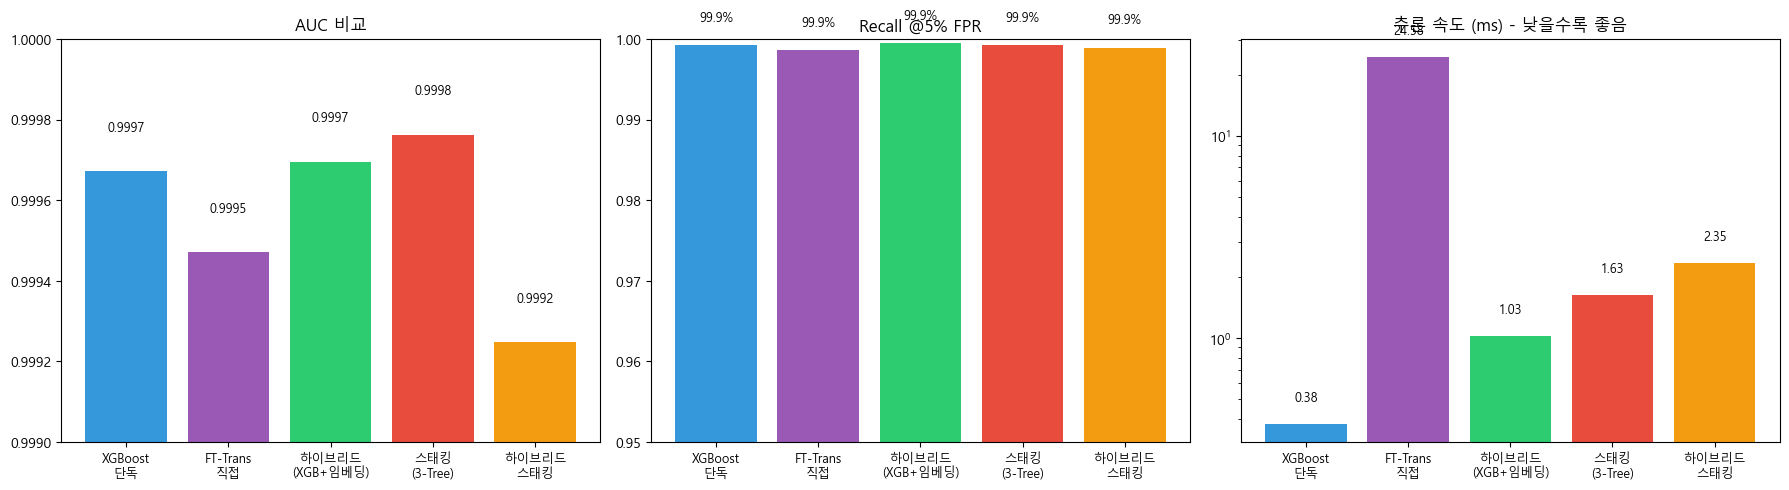


결과 이미지 저장: hybrid_serving_results.png


In [85]:
# 결과 정리: 5개 모델 비교
print("=" * 70)
print("5개 모델 비교 결과")
print("=" * 70)

# 결과 테이블
results_df = pd.DataFrame({
    '모델': ['XGBoost 단독', 'FT-Transformer', '하이브리드\n(XGB+임베딩)', '스태킹\n(3-Tree)', '하이브리드\n스태킹'],
    'AUC': [xgb_baseline_auc, tf_auc, xgb_hybrid_auc, stacking_auc, hybrid_stacking_auc],
    'Recall@5%FPR': [xgb_baseline_recall, tf_recall, xgb_hybrid_recall, stacking_recall, hybrid_stacking_recall],
    '추론속도(ms)': [
        np.mean(xgb_only_latencies), 
        tf_direct_latency, 
        np.mean(hybrid_latencies),
        np.mean(stacking_latencies),
        np.mean(hybrid_stacking_latencies)
    ]
})

print(results_df.to_string(index=False))

# 시각화
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

models = ['XGBoost\n단독', 'FT-Trans\n직접', '하이브리드\n(XGB+임베딩)', '스태킹\n(3-Tree)', '하이브리드\n스태킹']
colors = ['#3498db', '#9b59b6', '#2ecc71', '#e74c3c', '#f39c12']

# AUC
aucs = [xgb_baseline_auc, tf_auc, xgb_hybrid_auc, stacking_auc, hybrid_stacking_auc]
axes[0].bar(models, aucs, color=colors)
axes[0].set_title('AUC 비교', fontsize=12)
axes[0].set_ylim(0.999, 1.0)
axes[0].tick_params(axis='x', labelsize=9)
for i, v in enumerate(aucs):
    axes[0].text(i, v + 0.0001, f'{v:.4f}', ha='center', fontsize=9)

# Recall @5% FPR
recalls = [xgb_baseline_recall, tf_recall, xgb_hybrid_recall, stacking_recall, hybrid_stacking_recall]
axes[1].bar(models, recalls, color=colors)
axes[1].set_title('Recall @5% FPR', fontsize=12)
axes[1].set_ylim(0.95, 1.0)
axes[1].tick_params(axis='x', labelsize=9)
for i, v in enumerate(recalls):
    axes[1].text(i, v + 0.003, f'{v:.1%}', ha='center', fontsize=9)

# 추론 속도 (로그 스케일)
latencies = [
    np.mean(xgb_only_latencies), tf_direct_latency, np.mean(hybrid_latencies),
    np.mean(stacking_latencies), np.mean(hybrid_stacking_latencies)
]
axes[2].bar(models, latencies, color=colors)
axes[2].set_title('추론 속도 (ms) - 낮을수록 좋음', fontsize=12)
axes[2].set_yscale('log')
axes[2].tick_params(axis='x', labelsize=9)
for i, v in enumerate(latencies):
    axes[2].text(i, v * 1.3, f'{v:.2f}', ha='center', fontsize=9)

plt.tight_layout()
plt.savefig('hybrid_serving_results.png', dpi=150, bbox_inches='tight')
plt.show()
print("\n결과 이미지 저장: hybrid_serving_results.png")

---

## 10. 면접 Q&A (5개 모델 비교)

In [ ]:
print("=" * 70)
print("면접 Q&A (5개 모델 비교)")
print("=" * 70)
print()
print('Q: "왜 5가지 모델을 비교했나요?"')
print('A: "동일한 PaySim 데이터에서 공정 비교를 위해서입니다.')
print('   1. XGBoost 단독 - 베이스라인 (빠르고 해석 가능)')
print('   2. FT-Transformer - DL 단독 (높은 표현력)')
print('   3. 하이브리드 (XGB+임베딩) - NVIDIA Blueprint 패턴')
print('   4. 스태킹 (3-Tree) - 트리 앙상블 다양성')
print('   5. 하이브리드 스태킹 - 스태킹 + DL 임베딩 결합"')
print()
print('Q: "스태킹이 하이브리드보다 나은 점은?"')
print('A: "스태킹은 DL 없이도 다양성을 확보합니다.')
print('   XGB/LGBM/CatBoost는 각각 다른 정규화 방식을 써서,')
print('   메타 모델이 각 모델의 강점을 조합합니다.')
print('   추론 속도도 DL 없이 ~1.2ms로 실용적입니다."')
print()
print('Q: "하이브리드 스태킹의 장단점은?"')
print('A: "장점: 스태킹 다양성 + DL 표현력 결합으로 이론상 최고 성능.')
print('   단점: 복잡도가 높고 (Base 3개 + DL + Meta),')
print('   추론 속도가 스태킹 대비 느립니다 (Redis 조회 추가).')
print('   성능 개선 폭이 작으면 실무에서는 단순 모델 선호합니다."')
print()
print('Q: "실무에서 어떤 모델을 선택하겠나요?"')
print('A: "상황에 따라 다릅니다:')
print('   - 속도 중시: XGBoost 단독 (~0.4ms)')
print('   - 균형: 하이브리드 (~1ms, Recall 개선)')
print('   - 비용 민감: 스태킹 (DL 인프라 불필요)')
print('   PaySim에서는 성능 차이가 작아서 XGBoost 단독도 충분합니다."')
print()
print('Q: "하이브리드 아키텍처의 핵심은?"')
print(f'A: "Transformer 직접 추론 {tf_direct_latency:.1f}ms를')
print(f'   배치 임베딩 + Redis 캐싱으로 {np.mean(hybrid_latencies):.1f}ms로 줄였습니다.')
print(f'   {tf_direct_latency / np.mean(hybrid_latencies):.0f}배 개선이며, 이게 NVIDIA Blueprint 핵심입니다."')

In [ ]:
# Redis 정리 (선택)
# r.flushdb()
# print("Redis 데이터 정리 완료")

print("\n" + "=" * 70)
print("1-12 하이브리드 서빙 + 스태킹 비교 완료!")
print("=" * 70)
print("\n비교한 5개 모델:")
print("  1. XGBoost 단독 - 베이스라인")
print("  2. FT-Transformer - DL 직접 추론")
print("  3. 하이브리드 (XGB+임베딩) - NVIDIA Blueprint")
print("  4. 스태킹 (3-Tree) - XGB+LGBM+CatBoost")
print("  5. 하이브리드 스태킹 - 스태킹 + DL 임베딩")
print("\n저장된 파일:")
print("  - models/ft_transformer_paysim/ (FT-Transformer)")
print("  - models/xgb_hybrid.joblib (하이브리드 XGBoost)")
print("  - hybrid_serving_results.png (5개 모델 비교 시각화)")